In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import pickle
import os
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm

In [22]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")

In [23]:
df = pd.read_csv('dataset.csv', parse_dates=['Date'], dayfirst=True)

In [24]:
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197161 entries, 0 to 197160
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   SN         197161 non-null  int64         
 1   Commodity  197161 non-null  object        
 2   Date       197161 non-null  datetime64[ns]
 3   Unit       197161 non-null  object        
 4   Minimum    197161 non-null  int64         
 5   Maximum    197161 non-null  int64         
 6   Average    197161 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 10.5+ MB
None


In [25]:
print("\nFirst 5 rows:")
print(df.head())


First 5 rows:
   SN            Commodity       Date Unit  Minimum  Maximum  Average
0   0   Tomato Big(Nepali) 2013-06-16   Kg       35       40     37.5
1   1  Tomato Small(Local) 2013-06-16   Kg       26       32     29.0
2   2           Potato Red 2013-06-16   Kg       20       21     20.5
3   3         Potato White 2013-06-16   Kg       15       16     15.5
4   4   Onion Dry (Indian) 2013-06-16   Kg       28       30     29.0


In [26]:
# Check for null values
print("Null values before handling:")
print(df.isnull().sum())

Null values before handling:
SN           0
Commodity    0
Date         0
Unit         0
Minimum      0
Maximum      0
Average      0
dtype: int64


In [27]:
# Handle null values - fill with forward fill for time series
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)  # in case first values are null

In [28]:
# Check for duplicates
print("\nDuplicate rows before handling:", df.duplicated().sum())
df.drop_duplicates(inplace=True)


Duplicate rows before handling: 0


In [29]:
# Handle categorical values - 'Commodity' and 'Unit' are categorical
print("\nUnique Commodities:", df['Commodity'].unique())
print("Unique Units:", df['Unit'].unique())


Unique Commodities: ['Tomato Big(Nepali)' 'Tomato Small(Local)' 'Potato Red' 'Potato White'
 'Onion Dry (Indian)' 'Carrot(Local)' 'Cabbage(Local)' 'Cauli Local'
 'Raddish Red' 'Raddish White(Local)' 'Brinjal Long' 'Brinjal Round'
 'Cow pea(Long)' 'Green Peas' 'French Bean(Local)' 'Soyabean Green'
 'Bitter Gourd' 'Bottle Gourd' 'Pointed Gourd(Local)' 'Snake Gourd'
 'Smooth Gourd' 'Sponge Gourd' 'Pumpkin' 'Squash(Long)' 'Turnip' 'Okara'
 'Christophine' 'Brd Leaf Mustard' 'Spinach Leaf' 'Cress Leaf'
 'Mustard Leaf' 'Fenugreek Leaf' 'Onion Green' 'Mushroom(Kanya)'
 'Asparagus' 'Neuro' 'Brocauli' 'Sugarbeet' 'Drumstick' 'Red Cabbbage'
 'Lettuce' 'Celery' 'Parseley' 'Fennel Leaf' 'Mint' 'Turnip A' 'Tamarind'
 'Bamboo Shoot' 'Tofu' 'Gundruk' 'Apple(Jholey)' 'Banana' 'Lime'
 'Pomegranate' 'Mango(Maldah)' 'Grapes(Green)' 'Water Melon(Green)'
 'Sweet Orange' 'Pineapple' 'Cucumber(Local)' 'Jack Fruit'
 'Papaya(Nepali)' 'Sugarcane' 'Ginger' 'Chilli Dry' 'Chilli Green'
 'Capsicum' 'Garlic Green' '

In [30]:
# Since we'll filter by commodity, we don't need to encode it now
# Unit is consistent (all 'Kg'), so we can drop it
if df['Unit'].nunique() == 1:
    df.drop('Unit', axis=1, inplace=True)

In [31]:
# Convert date to datetime and set as index for time series analysis
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.sort_values('Date', inplace=True)

In [32]:
# Add time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['DayOfYear'] = df['Date'].dt.dayofyear

In [33]:
print("\nAfter preprocessing:")
print(df.head())


After preprocessing:
    SN           Commodity       Date Unit  Minimum  Maximum  Average  Year  \
0    0  Tomato Big(Nepali) 2013-06-16   Kg       35       40     37.5  2013   
53  53         Pomegranate 2013-06-16   Kg      200      220    210.0  2013   
52  52                Lime 2013-06-16   Kg      200      400    300.0  2013   
51  51              Banana 2013-06-16  Doz       70       80     75.0  2013   
50  50       Apple(Jholey) 2013-06-16   Kg      100      120    110.0  2013   

    Month  Day  DayOfWeek  DayOfYear  
0       6   16          6        167  
53      6   16          6        167  
52      6   16          6        167  
51      6   16          6        167  
50      6   16          6        167  


In [34]:
def process_commodity_data(commodity_df):
    """Process data for a specific commodity"""
    # Outlier detection using IQR
    for col in ['Minimum', 'Maximum', 'Average']:
        Q1 = commodity_df[col].quantile(0.25)
        Q3 = commodity_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap outliers
        commodity_df[col] = np.where(commodity_df[col] < lower_bound, lower_bound, 
                                    np.where(commodity_df[col] > upper_bound, upper_bound, 
                                            commodity_df[col]))
    
    # Feature selection - we'll focus on 'Average' price for forecasting
    # But keep other features for potential multivariate analysis
    ts_data = commodity_df.set_index('Date')['Average']
    
    # Feature scaling - we'll scale during modeling
    return ts_data

In [35]:
def visualize_commodity_data(ts_data, commodity_name):
    """Generate visualization plots for a commodity"""
    plt.figure(figsize=(15, 12))
    
    # Create directory for saving plots
    os.makedirs('visualizations', exist_ok=True)
    
    # Plot time series
    plt.subplot(3, 2, 1)
    ts_data.plot(title=f'{commodity_name} Price Over Time')
    
    # Plot seasonal decompose
    plt.subplot(3, 2, 2)
    result = seasonal_decompose(ts_data, model='additive', period=30)
    result.plot()
    
    # Plot ACF and PACF
    plt.subplot(3, 2, 3)
    plot_acf(ts_data, lags=50, ax=plt.gca())
    
    plt.subplot(3, 2, 4)
    plot_pacf(ts_data, lags=50, ax=plt.gca())
    
    # Plot distribution
    plt.subplot(3, 2, 5)
    sns.histplot(ts_data, kde=True)
    plt.title('Price Distribution')
    
    # Plot boxplot by month
    plt.subplot(3, 2, 6)
    sns.boxplot(x=ts_data.index.month, y=ts_data.values)
    plt.title('Monthly Price Distribution')
    plt.xlabel('Month')
    
    plt.tight_layout()
    plt.savefig(f'visualizations/{commodity_name}_eda.png')
    plt.show()

In [36]:
def train_test_split(ts_data, test_size=0.2):
    """Split time series data into train and test sets"""
    split_idx = int(len(ts_data) * (1 - test_size))
    train = ts_data[:split_idx]
    test = ts_data[split_idx:]
    return train, test

In [37]:
def build_arima_model(train_data):
    """Build and train ARIMA model with auto parameter selection"""
    # Auto ARIMA to find best parameters
    model = pm.auto_arima(train_data, 
                          seasonal=True, 
                          m=12, 
                          stepwise=True,
                          suppress_warnings=True, 
                          trace=True)
    
    print(f"Best ARIMA parameters: {model.order}")
    return model

In [38]:
def build_lstm_model(train_data, n_steps=30):
    """Build and train LSTM model"""
    # Scale data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(train_data.values.reshape(-1, 1))
    
    # Prepare data for LSTM
    X, y = [], []
    for i in range(n_steps, len(scaled_data)):
        X.append(scaled_data[i-n_steps:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    
    # Reshape for LSTM [samples, timesteps, features]
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    # Split into train and validation
    split_idx = int(0.8 * len(X))
    X_train, X_val = X[:split_idx], X[split_idx:]
    y_train, y_val = y[:split_idx], y[split_idx:]
    
    # Build model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(n_steps, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train model
    history = model.fit(X_train, y_train, 
                       epochs=50, 
                       batch_size=32, 
                       validation_data=(X_val, y_val),
                       callbacks=[early_stop],
                       verbose=1)
    
    return model, scaler, n_steps, history

In [49]:
def evaluate_model(model, model_type, train_data, test_data, scaler=None, n_steps=None):
    """Evaluate model performance"""
    if model_type == 'ARIMA':
        # ARIMA evaluation - skip first 'd' points where d is the differencing order
        d = model.order[1]
        train_pred = model.predict_in_sample(start=d, end=len(train_data)-1)
        
        # Align predictions with original data
        full_train_pred = np.empty(len(train_data))
        full_train_pred[:] = np.nan
        full_train_pred[d:] = train_pred
        
        test_pred, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)
        
        # Calculate metrics (only on non-nan values)
        train_mae = mean_absolute_error(train_data[d:], train_pred)
        train_rmse = np.sqrt(mean_squared_error(train_data[d:], train_pred))
        test_mae = mean_absolute_error(test_data, test_pred)
        test_rmse = np.sqrt(mean_squared_error(test_data, test_pred))
        
        return {
            'train_pred': pd.Series(full_train_pred, index=train_data.index),
            'test_pred': pd.Series(test_pred, index=test_data.index),
            'conf_int': conf_int,
            'metrics': {
                'Train MAE': train_mae,
                'Train RMSE': train_rmse,
                'Test MAE': test_mae,
                'Test RMSE': test_rmse
            }
        }
    
    elif model_type == 'LSTM':
        # Prepare data for LSTM prediction
        combined_data = pd.concat([train_data, test_data])
        scaled_data = scaler.transform(combined_data.values.reshape(-1, 1))
        
        # Prepare sequences
        X_test = []
        for i in range(n_steps, len(scaled_data)):
            X_test.append(scaled_data[i-n_steps:i, 0])
        X_test = np.array(X_test)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        
        # Predict
        scaled_pred = model.predict(X_test)
        predictions = scaler.inverse_transform(scaled_pred).flatten()
        
        # Align predictions with test data
        test_pred = predictions[-len(test_data):]
        train_pred = predictions[:len(train_data)-n_steps]
        
        # Pad train_pred with NaNs for alignment
        train_pred = np.concatenate([np.array([np.nan]*n_steps), train_pred])
        
        # Calculate metrics
        train_mae = mean_absolute_error(train_data[n_steps:], train_pred[n_steps:])
        train_rmse = np.sqrt(mean_squared_error(train_data[n_steps:], train_pred[n_steps:]))
        test_mae = mean_absolute_error(test_data, test_pred)
        test_rmse = np.sqrt(mean_squared_error(test_data, test_pred))
        
        return {
            'train_pred': pd.Series(train_pred, index=train_data.index),
            'test_pred': pd.Series(test_pred, index=test_data.index),
            'metrics': {
                'Train MAE': train_mae,
                'Train RMSE': train_rmse,
                'Test MAE': test_mae,
                'Test RMSE': test_rmse
            }
        }

In [40]:
def compare_models(arima_results, lstm_results, commodity_name):
    """Compare model performance and visualize results"""
    # Extract metrics
    arima_metrics = arima_results['metrics']
    lstm_metrics = lstm_results['metrics']
    
    # Create comparison dataframe
    metrics_df = pd.DataFrame({
        'ARIMA': arima_metrics,
        'LSTM': lstm_metrics
    })
    
    # Plot metrics comparison
    plt.figure(figsize=(12, 6))
    metrics_df.plot(kind='bar')
    plt.title(f'Model Comparison for {commodity_name}')
    plt.ylabel('Error')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'visualizations/{commodity_name}_model_comparison.png')
    plt.show()
    
    # Plot predictions
    plt.figure(figsize=(15, 7))
    
    # Get the common test index (assuming same test set was used)
    test_index = lstm_results['test_pred'].index if isinstance(lstm_results['test_pred'], pd.Series) else range(len(lstm_results['test_pred']))
    
    plt.plot(arima_results['train_pred'], label='ARIMA Train Pred', alpha=0.7)
    plt.plot(test_index, arima_results['test_pred'], label='ARIMA Test Pred', linestyle='--')
    if 'conf_int' in arima_results:
        plt.fill_between(test_index, 
                        arima_results['conf_int'][:, 0], 
                        arima_results['conf_int'][:, 1], 
                        color='blue', alpha=0.1)
    
    plt.plot(lstm_results['train_pred'], label='LSTM Train Pred', alpha=0.7)
    plt.plot(test_index, lstm_results['test_pred'], label='LSTM Test Pred', linestyle='--')
    
    plt.title(f'Price Predictions for {commodity_name}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'visualizations/{commodity_name}_predictions.png')
    plt.show()
    
    return metrics_df

In [41]:
def tune_lstm_model(train_data, n_steps=30):
    """Perform cross-validation and tuning for LSTM"""
    # Scale data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(train_data.values.reshape(-1, 1))
    
    # Prepare data for LSTM
    X, y = [], []
    for i in range(n_steps, len(scaled_data)):
        X.append(scaled_data[i-n_steps:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    # Time Series Cross Validation
    tscv = TimeSeriesSplit(n_splits=3)
    
    best_score = float('inf')
    best_model = None
    
    # Try different architectures
    for units in [32, 50, 64]:
        for layers in [1, 2]:
            print(f"\nTesting LSTM with {layers} layer(s) and {units} units")
            
            cv_scores = []
            
            for train_idx, val_idx in tscv.split(X):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]
                
                model = Sequential()
                model.add(LSTM(units, return_sequences=(layers > 1), input_shape=(n_steps, 1)))
                if layers > 1:
                    model.add(LSTM(units))
                model.add(Dense(1))
                model.compile(optimizer='adam', loss='mse')
                
                model.fit(X_train, y_train, 
                         epochs=30, 
                         batch_size=32, 
                         validation_data=(X_val, y_val),
                         verbose=0)
                
                score = model.evaluate(X_val, y_val, verbose=0)
                cv_scores.append(score)
            
            avg_score = np.mean(cv_scores)
            print(f"Average validation loss: {avg_score:.4f}")
            
            if avg_score < best_score:
                best_score = avg_score
                best_params = {'units': units, 'layers': layers}
                best_model = model
    
    print(f"\nBest LSTM parameters: {best_params} with validation loss: {best_score:.4f}")
    return best_model, scaler, n_steps

In [42]:
def save_model(model, model_type, commodity_name):
    """Save trained model to file"""
    os.makedirs('saved_models', exist_ok=True)
    filename = f"saved_models/{commodity_name.replace(' ', '_')}_{model_type}.pkl"
    
    if model_type == 'ARIMA':
        with open(filename, 'wb') as f:
            pickle.dump(model, f)
    elif model_type == 'LSTM':
        model.save(filename.replace('.pkl', '.h5'))
    
    print(f"Saved {model_type} model to {filename}")

In [43]:
def load_model(model_type, commodity_name):
    """Load trained model from file"""
    filename = f"saved_models/{commodity_name.replace(' ', '_')}_{model_type}"
    
    if model_type == 'ARIMA':
        with open(filename + '.pkl', 'rb') as f:
            return pickle.load(f)
    elif model_type == 'LSTM':
        from tensorflow.keras.models import load_model
        return load_model(filename + '.h5')

In [44]:
def forecast_future(model, model_type, history, steps, scaler=None, n_steps=None):
    """Forecast future values using the trained model"""
    if model_type == 'ARIMA':
        forecast, conf_int = model.predict(n_periods=steps, return_conf_int=True)
        return forecast, conf_int
    
    elif model_type == 'LSTM':
        # Prepare last sequence from history
        last_sequence = scaler.transform(history.values.reshape(-1, 1))[-n_steps:]
        
        forecasts = []
        for _ in range(steps):
            # Reshape for prediction
            X = last_sequence.reshape(1, n_steps, 1)
            
            # Predict next value
            pred = model.predict(X, verbose=0)
            forecasts.append(pred[0, 0])
            
            # Update sequence
            last_sequence = np.roll(last_sequence, -1)
            last_sequence[-1] = pred[0, 0]
        
        # Inverse transform
        forecasts = scaler.inverse_transform(np.array(forecasts).reshape(-1, 1)).flatten()
        
        return forecasts, None  # No confidence intervals for LSTM

In [45]:
def commodity_price_pipeline(commodity_name, steps_to_forecast=30):
    """Complete pipeline for commodity price forecasting"""
    print(f"\n{'='*50}")
    print(f"Processing commodity: {commodity_name}")
    print(f"{'='*50}")
    
    # Filter data for the selected commodity
    commodity_df = df[df['Commodity'] == commodity_name].copy()
    
    if len(commodity_df) < 100:
        print(f"Warning: Insufficient data ({len(commodity_df)} records) for {commodity_name}")
        return None
    
    # Process data
    ts_data = process_commodity_data(commodity_df)
    
    # Visualize data
    visualize_commodity_data(ts_data, commodity_name)
    
    # Train-test split
    train_data, test_data = train_test_split(ts_data)
    
    # Model training
    print("\nTraining ARIMA model...")
    arima_model = build_arima_model(train_data)
    
    print("\nTraining LSTM model...")
    lstm_model, lstm_scaler, n_steps, lstm_history = build_lstm_model(train_data)
    
    # Model evaluation
    print("\nEvaluating ARIMA model...")
    arima_results = evaluate_model(arima_model, 'ARIMA', train_data, test_data)
    
    print("\nEvaluating LSTM model...")
    lstm_results = evaluate_model(lstm_model, 'LSTM', train_data, test_data, lstm_scaler, n_steps)
    
    # Compare models
    metrics_df = compare_models(arima_results, lstm_results, commodity_name)
    
    # Select best model based on test RMSE
    if arima_results['metrics']['Test RMSE'] < lstm_results['metrics']['Test RMSE']:
        best_model = arima_model
        best_model_type = 'ARIMA'
        best_scaler = None
    else:
        best_model = lstm_model
        best_model_type = 'LSTM'
        best_scaler = lstm_scaler
    
    print(f"\nBest model for {commodity_name}: {best_model_type}")
    
    # Hyperparameter tuning on best model
    print("\nPerforming hyperparameter tuning on best model...")
    if best_model_type == 'LSTM':
        tuned_model, best_scaler, n_steps = tune_lstm_model(train_data)
        best_model = tuned_model
    
    # Save best model
    save_model(best_model, best_model_type, commodity_name)
    
    # Forecast future values
    print(f"\nForecasting next {steps_to_forecast} days...")
    forecast, conf_int = forecast_future(best_model, best_model_type, 
                                       ts_data, steps_to_forecast, 
                                       best_scaler, n_steps)
    
    # Create future dates
    last_date = ts_data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), 
                                periods=steps_to_forecast)
    
    # Plot forecast
    plt.figure(figsize=(15, 7))
    plt.plot(ts_data.index, ts_data.values, label='Historical Prices')
    plt.plot(future_dates, forecast, label='Forecasted Prices', linestyle='--')
    
    if conf_int is not None:
        plt.fill_between(future_dates, 
                        conf_int[:, 0], 
                        conf_int[:, 1], 
                        color='orange', alpha=0.2, label='Confidence Interval')
    
    plt.title(f'{commodity_name} Price Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'visualizations/{commodity_name}_forecast.png')
    plt.show()
    
    # Create forecast dataframe
    forecast_df = pd.DataFrame({
        'Date': future_dates,
        'Forecasted_Price': forecast
    })
    
    if conf_int is not None:
        forecast_df['Lower_Bound'] = conf_int[:, 0]
        forecast_df['Upper_Bound'] = conf_int[:, 1]
    
    print("\nForecasted Prices:")
    print(forecast_df.head())
    
    return {
        'commodity': commodity_name,
        'best_model_type': best_model_type,
        'metrics': metrics_df,
        'forecast': forecast_df
    }

In [46]:
# Get list of available commodities
available_commodities = df['Commodity'].unique()
print("Available Commodities:")
for i, comm in enumerate(available_commodities):
    print(f"{i+1}. {comm}")

Available Commodities:
1. Tomato Big(Nepali)
2. Pomegranate
3. Lime
4. Banana
5. Apple(Jholey)
6. Gundruk
7. Tofu
8. Bamboo Shoot
9. Tamarind
10. Turnip A
11. Mint
12. Fennel Leaf
13. Parseley
14. Celery
15. Lettuce
16. Red Cabbbage
17. Grapes(Green)
18. Drumstick
19. Water Melon(Green)
20. Pineapple
21. Fish Fresh
22. Clive Green
23. Clive Dry
24. Garlic Dry Nepali
25. Garlic Dry Chinese
26. Coriander Green
27. Garlic Green
28. Capsicum
29. Chilli Green
30. Chilli Dry
31. Ginger
32. Sugarcane
33. Papaya(Nepali)
34. Jack Fruit
35. Cucumber(Local)
36. Sweet Orange
37. Sugarbeet
38. Mango(Maldah)
39. Neuro
40. Soyabean Green
41. French Bean(Local)
42. Green Peas
43. Cow pea(Long)
44. Brinjal Round
45. Brinjal Long
46. Raddish White(Local)
47. Raddish Red
48. Cauli Local
49. Cabbage(Local)
50. Carrot(Local)
51. Onion Dry (Indian)
52. Potato White
53. Potato Red
54. Brocauli
55. Bitter Gourd
56. Bottle Gourd
57. Tomato Small(Local)
58. Snake Gourd
59. Pointed Gourd(Local)
60. Mushroom(Kany

In [47]:
# Select commodity (change this to the desired commodity)
selected_commodity = available_commodities[0]  # Default to first commodity
print(f"\nSelected Commodity: {selected_commodity}")


Selected Commodity: Tomato Big(Nepali)



Processing commodity: Tomato Big(Nepali)


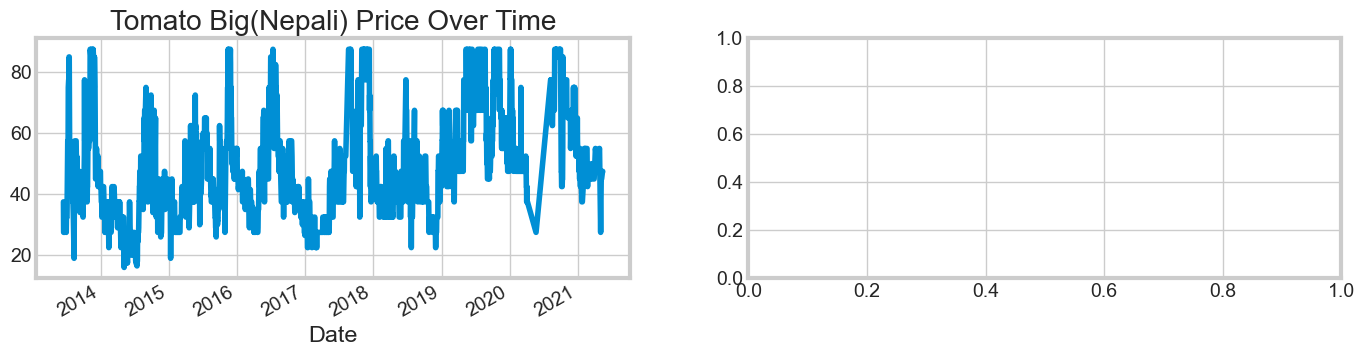

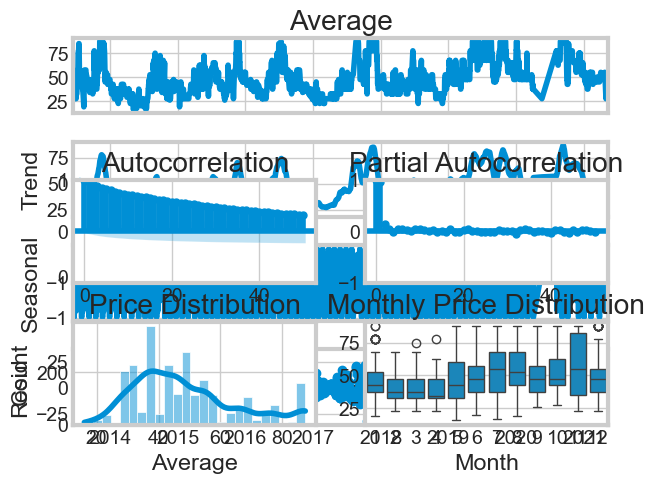


Training ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=3.37 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=12346.711, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=12299.006, Time=0.37 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=12293.514, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=12344.740, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=12291.564, Time=0.13 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=12293.513, Time=0.30 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=12295.508, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=12281.791, Time=0.41 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=12283.541, Time=0.86 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=12283.540, Time=1.11 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=12285.544, Time=1.31 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=12297.051, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=12293.489, 

<Figure size 1200x600 with 0 Axes>

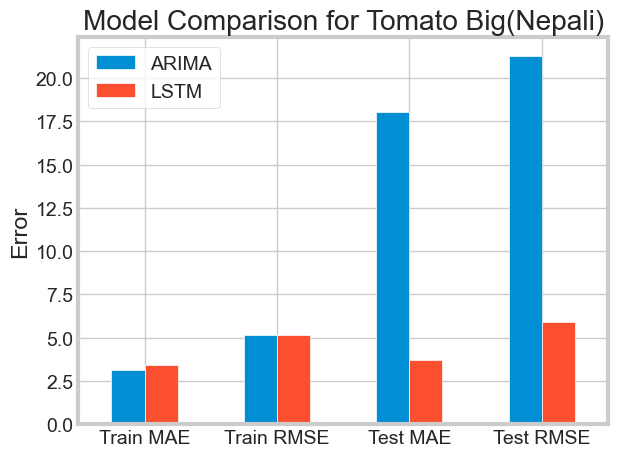

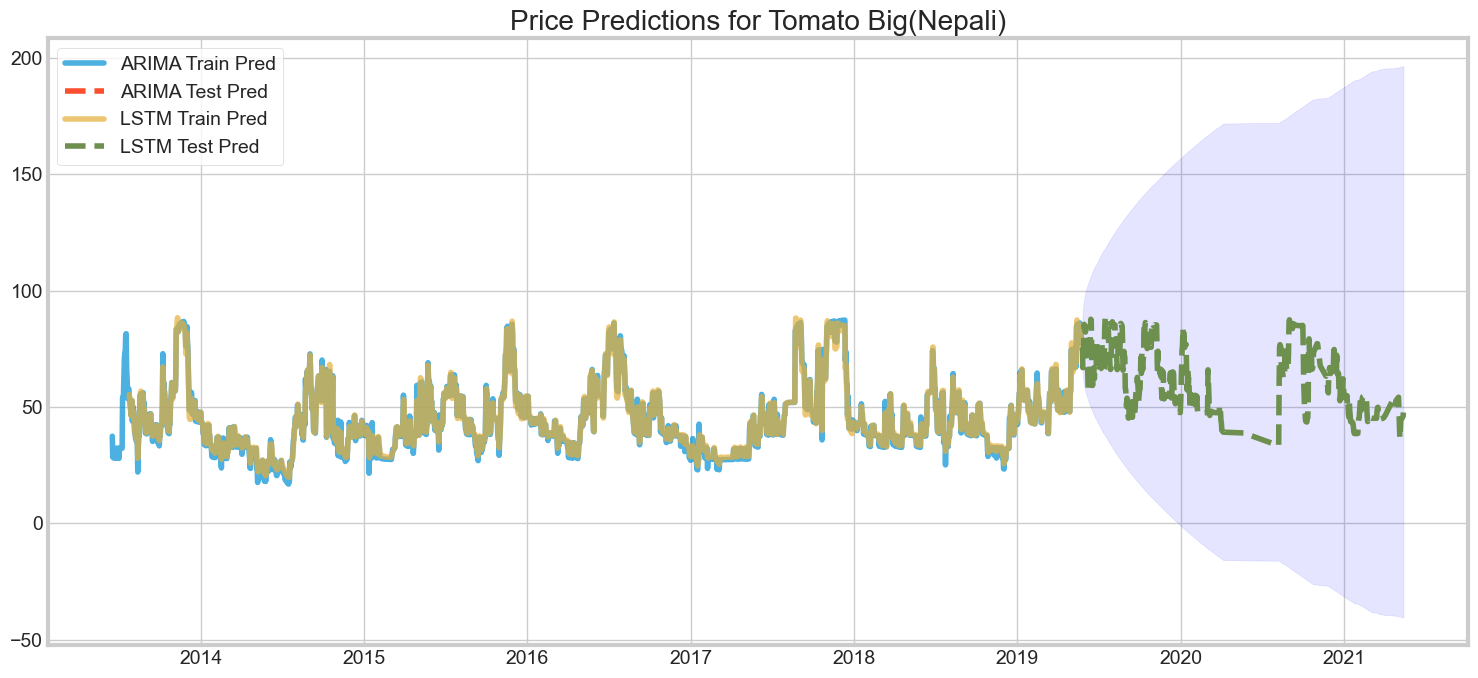


Best model for Tomato Big(Nepali): LSTM

Performing hyperparameter tuning on best model...

Testing LSTM with 1 layer(s) and 32 units
Average validation loss: 0.0060

Testing LSTM with 2 layer(s) and 32 units
Average validation loss: 0.0064

Testing LSTM with 1 layer(s) and 50 units
Average validation loss: 0.0054

Testing LSTM with 2 layer(s) and 50 units
Average validation loss: 0.0056

Testing LSTM with 1 layer(s) and 64 units
Average validation loss: 0.0053

Testing LSTM with 2 layer(s) and 64 units
Average validation loss: 0.0077

Best LSTM parameters: {'units': 64, 'layers': 1} with validation loss: 0.0053
Saved LSTM model to saved_models/Tomato_Big(Nepali)_LSTM.pkl

Forecasting next 30 days...


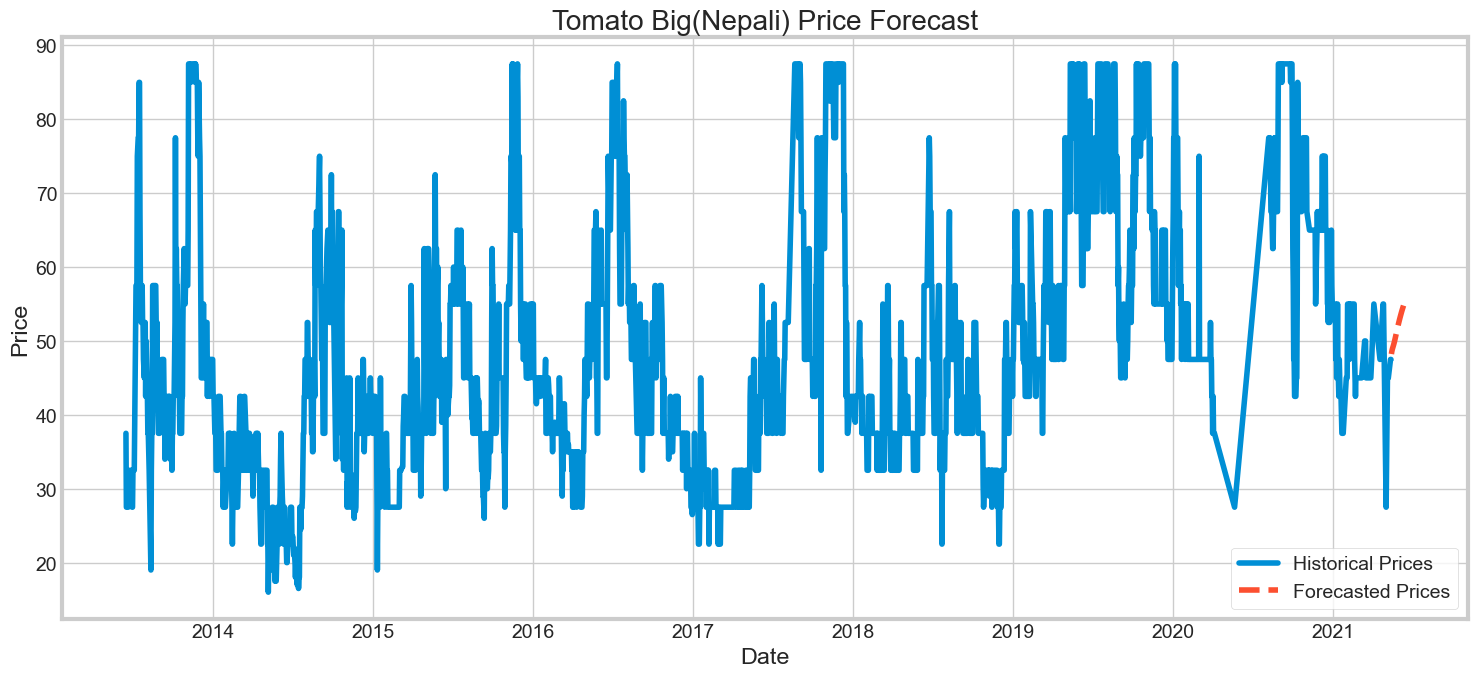


Forecasted Prices:
        Date  Forecasted_Price
0 2021-05-14         48.230869
1 2021-05-15         48.587620
2 2021-05-16         48.849789
3 2021-05-17         49.061581
4 2021-05-18         49.258087

Final Results:
Best Model: LSTM

Performance Metrics:
                ARIMA      LSTM
Train MAE    3.125328  3.407464
Train RMSE   5.172838  5.165061
Test MAE    18.042442  3.682073
Test RMSE   21.282708  5.883964

Forecast Summary:
                      Date  Forecasted_Price
count                   30         30.000000
mean   2021-05-28 12:00:00         51.797356
min    2021-05-14 00:00:00         48.230869
25%    2021-05-21 06:00:00         49.978059
50%    2021-05-28 12:00:00         51.899221
75%    2021-06-04 18:00:00         53.599851
max    2021-06-12 00:00:00         55.022888
std                    NaN          2.099719


In [50]:
# Run pipeline
results = commodity_price_pipeline(selected_commodity, steps_to_forecast=30)

# Display final results
if results:
    print("\nFinal Results:")
    print(f"Best Model: {results['best_model_type']}")
    print("\nPerformance Metrics:")
    print(results['metrics'])
    print("\nForecast Summary:")
    print(results['forecast'].describe())